# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

Перед тем, как проводить исследование, проверим данные на наличие пропусков. Заполним их там, где это возможно. Затем, изменим тип данных и удалим неявные дубликаты. После этого, добавим в датафрейм новые столбцы, которые пригодятся нам для рассчетов и построения графиков. После чего, приступим непосредственно к анализу данных. В конце составим общий вывод, где будут отражены основные результаты исследования.

## Откроем файл с данными и изучим общую информацию

Откроем csv-файл с данными, и изучим таблицу. Для этого сначала подключим библиотеку *pandas,* затем выведем первые 5 строк.

In [ ]:
import pandas as pd

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Вывод показал, что таблица некорректна. Для правильного отображения был указан тип разделителя через параметр *sep.*

Для вывода информации о всей таблице (количество строк, столбцов, типы данных в каждом столбце, количество ненулевых значений в каждом столбце) воспользуемся методом *info().*

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Можно уже сейчас увидеть, что во многих столбцах есть пропущенные значения. Также, в столбце 9, вместо булева типа, указан тип данных *object.* В столбце 3 (дата публикации) тип данных должен быть *datetime.* А в столбцах 6, 13, 17, 19 и 21 не может быть типа данных *float,* так как данные там всегда целочисленны. С этими данными мы разберемся позже.

А пока визуализируем данные тех столбцов, где указан числовой тип данных *(int, float).* Для этого построим гистограммы для каждого такого столбца с помощью метода *hist(),* и зададим размер графиков и количество корзин.

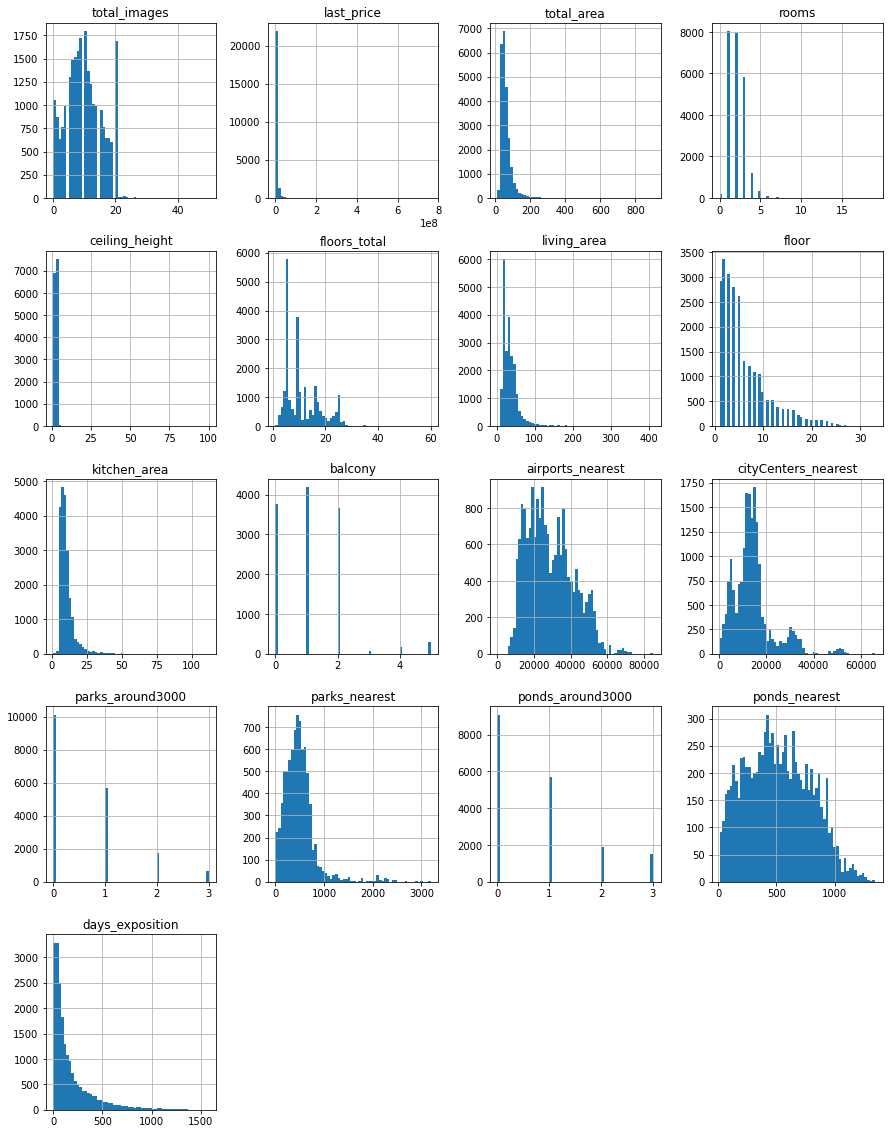

In [ ]:
import matplotlib.pyplot as plt

data.hist(bins=60, figsize=(15, 20))
plt.show()

По нескольким графикам можно увидеть, что в данных есть выбросы (аномалии), так как у графиков нет нормального распределения или распределения Пуассона.

## Выполним предобработку данных

### Поиск пропущенных значений и их обработка

Перейдем к поиску пропущенных значений и их обработке.

Для начала выясним количество пропущенных значений в каждом столбце датафрейма.

In [ ]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Для того, чтобы понять, какими значениями заполнять пропуски, и заполнять ли их вообще, приступим к анализу каждого столбца.

**2.1.1. Высота потолков**

Начнем с высоты потолков. Выведем на экран уникальные значения этого столбца.

In [ ]:
data['ceiling_height'].sort_values(ascending=False).unique()

array([100.  ,  32.  ,  27.5 ,  27.  ,  26.  ,  25.  ,  24.  ,  22.6 ,
        20.  ,  14.  ,  10.3 ,   8.3 ,   8.  ,   6.  ,   5.8 ,   5.6 ,
         5.5 ,   5.3 ,   5.2 ,   5.  ,   4.9 ,   4.8 ,   4.7 ,   4.65,
         4.5 ,   4.45,   4.4 ,   4.37,   4.3 ,   4.25,   4.2 ,   4.19,
         4.15,   4.14,   4.1 ,   4.06,   4.  ,   3.98,   3.95,   3.93,
         3.9 ,   3.88,   3.87,   3.86,   3.85,   3.84,   3.83,   3.82,
         3.8 ,   3.78,   3.76,   3.75,   3.7 ,   3.69,   3.68,   3.67,
         3.66,   3.65,   3.63,   3.62,   3.6 ,   3.59,   3.58,   3.57,
         3.56,   3.55,   3.54,   3.53,   3.52,   3.51,   3.5 ,   3.49,
         3.48,   3.47,   3.46,   3.45,   3.44,   3.43,   3.42,   3.4 ,
         3.39,   3.38,   3.37,   3.36,   3.35,   3.34,   3.33,   3.32,
         3.31,   3.3 ,   3.29,   3.28,   3.27,   3.26,   3.25,   3.24,
         3.23,   3.22,   3.21,   3.2 ,   3.18,   3.17,   3.16,   3.15,
         3.14,   3.13,   3.12,   3.11,   3.1 ,   3.09,   3.08,   3.07,
      

В значениях видны аномально высокие и слишком низкие показатели. Поэтому заполнение пропусков через среднее значение может оказаться недостоверным. Вместо этого лучше воспользоваться медианным значением, которое слабо реагирует на выбросы.

In [ ]:
ceiling_median = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_median)
data['ceiling_height'].isna().sum()

0

Пропущенных значений не осталось, идем дальше.

**2.1.2. Жилая площадь**

В столбце, где указано число этажей в доме, очень малое количество пропусков, которое не окажет влияния на выборку. Поэтому, можно пропустить этот столбец, и перейти к следующему - жилая площадь. Проделаем уже привычный шаг, выведем уникальные значения.

In [ ]:
data['living_area'].sort_values(ascending=False).unique()

array([409.7, 409. , 347.5, ...,   3. ,   2. ,   nan])

На всякий случай проверим, есть ли в таблице строки, где сумма жилой площади и площади кухни больше, чем общая площадь.

In [ ]:
data.query('living_area + kitchen_area > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,NaN,...,6.20,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.65,18.0,20.00,9,NaN,...,5.00,NaN,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,NaN,...,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
601,12,5600000.0,53.70,2017-04-18T00:00:00,2,2.50,12.0,48.30,5,NaN,...,7.00,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0
696,1,3364930.0,34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,NaN,...,23.43,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21824,20,2450000.0,44.00,2019-02-12T00:00:00,2,27.00,2.0,38.00,2,False,...,8.60,2.0,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21868,12,2600000.0,34.30,2018-09-26T00:00:00,1,2.50,9.0,30.60,6,NaN,...,8.00,2.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,107.0
21915,14,11990000.0,91.40,2016-05-16T00:00:00,2,2.65,16.0,62.00,12,NaN,...,32.40,0.0,Санкт-Петербург,10934.0,12551.0,0.0,NaN,0.0,NaN,93.0
21956,0,5200000.0,46.00,2018-07-20T00:00:00,2,2.65,5.0,44.00,5,NaN,...,8.00,1.0,Санкт-Петербург,14103.0,15182.0,1.0,488.0,0.0,NaN,7.0


Мы видим макисмальные и минимальные значения, из которых можно сделать вывод, что в показателях столбца нет аномальных значений (в настоящее время показатели жилплощади в 2 и 3 квадратных метра выглядят не такими уж фантастичными). Однако, мы нашли 64 строки, где сумма жилой площади и площади кухни больше, чем общая площадь. Поэтому, не будем торопиться заполнять пропуски медианным или средним значением. Гораздо лучше будет определить долю жилой площади в общей площади объекта в тех строках данных, где сумма жилой площади и площади кухни не превышает 90 % от общей площади. Так как нет аномальных значений, посчитаем среднее от полученных значений.

In [ ]:
share = data.query('kitchen_area + living_area <= 0.9 * total_area')
share_living = (share['living_area'] / share['total_area'] * 100).mean().round(2)
print(share_living)

55.86


Средняя доля жилой площади от общей площади найдена - 55.86 %. Теперь, возьмем строки, где значения жилой площади пропущены, а также строки, в которых площадь кухни пропущена, либо занимает не более 34.14 % от общей площади (доля, не занятая жилой площадью, и с дополнительным вычетом в размере 10% от общей площади). Такой срез взят для того, чтобы новые значения не создали дополнительные аномалии, когда сумма жилой площади и площади кухни больше общей площади. С таким срезом можно смело вносить то значение, которое соответствует средней доле от общей площади.

In [ ]:
area_living = data.query('living_area.isna() and (kitchen_area <= total_area * 0.3414 or kitchen_area.isna())')
area_living = area_living['total_area'] * (share_living / 100).round(2)
data['living_area'] = data['living_area'].fillna(area_living)
data['living_area'].isna().sum()

29

Осталось 29 пропусков. Считаю необходимым эти пропуски оставить, чтобы не создавать новых некорректных строк данных. Снова посчитаем, изменилось ли количество строк с некорректными данными.

In [ ]:
data.query('living_area + kitchen_area > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,NaN,...,6.20,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.65,18.0,20.00,9,NaN,...,5.00,NaN,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,NaN,...,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
601,12,5600000.0,53.70,2017-04-18T00:00:00,2,2.50,12.0,48.30,5,NaN,...,7.00,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0
696,1,3364930.0,34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,NaN,...,23.43,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21824,20,2450000.0,44.00,2019-02-12T00:00:00,2,27.00,2.0,38.00,2,False,...,8.60,2.0,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21868,12,2600000.0,34.30,2018-09-26T00:00:00,1,2.50,9.0,30.60,6,NaN,...,8.00,2.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,107.0
21915,14,11990000.0,91.40,2016-05-16T00:00:00,2,2.65,16.0,62.00,12,NaN,...,32.40,0.0,Санкт-Петербург,10934.0,12551.0,0.0,NaN,0.0,NaN,93.0
21956,0,5200000.0,46.00,2018-07-20T00:00:00,2,2.65,5.0,44.00,5,NaN,...,8.00,1.0,Санкт-Петербург,14103.0,15182.0,1.0,488.0,0.0,NaN,7.0


Количество строк осталось прежним, поэтому можно идти дальше.

**2.1.3. Является ли объект апартаментами?**

В данном столбце обнаружено очень много пропусков. Вряд ли при заполнении объявления существенная часть пользователей могла забыть отметить, что объект является апартаментами.

Выдвинем гипотезу: значения пропущены, так как пользователи, чьи объекты не являются апартаментами, не сочли нужным делать об этом отметку.

Чтобы в этом убедиться, проанализируем имеющиеся строки данных.

In [ ]:
data.query('~is_apartment.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11,9,3300000.0,44.0,2018-08-27T00:00:00,2,2.65,5.0,31.0,4,False,...,6.0,1.0,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0
25,3,6800000.0,76.0,2015-10-01T00:00:00,2,2.75,23.0,39.0,18,False,...,15.0,2.0,Санкт-Петербург,34967.0,14640.0,0.0,NaN,1.0,564.0,300.0
29,9,8600000.0,100.0,2016-04-09T00:00:00,3,2.65,19.0,52.0,15,False,...,11.0,0.0,Санкт-Петербург,30394.0,11526.0,1.0,532.0,1.0,896.0,125.0
36,13,3790000.0,45.0,2017-01-25T00:00:00,2,2.65,9.0,27.0,9,False,...,6.3,2.0,Санкт-Петербург,49574.0,16461.0,1.0,459.0,0.0,NaN,139.0
41,16,7900000.0,74.0,2016-05-04T00:00:00,3,2.65,14.0,59.0,8,False,...,12.0,5.0,Санкт-Петербург,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23665,11,4250000.0,47.0,2016-05-20T00:00:00,1,2.65,6.0,18.2,1,False,...,14.6,0.0,Санкт-Петербург,20503.0,4946.0,2.0,624.0,1.0,519.0,131.0
23667,14,9990000.0,90.0,2017-01-23T00:00:00,3,3.06,17.0,55.0,9,False,...,11.0,2.0,Сестрорецк,56343.0,33272.0,0.0,NaN,1.0,545.0,86.0
23671,3,3450000.0,35.3,2017-04-14T00:00:00,1,2.50,9.0,17.5,4,False,...,7.5,2.0,Санкт-Петербург,21435.0,15261.0,1.0,334.0,1.0,232.0,21.0
23678,10,3500000.0,43.0,2016-05-19T00:00:00,2,2.50,3.0,26.1,2,False,...,4.9,1.0,Пушкин,15823.0,27977.0,0.0,NaN,1.0,1134.0,252.0


У нас есть информация о 2775 объектах недвижимости. Найдем в этом числе количество объектов, которые указаны как апартаменты.

In [ ]:
data.query('is_apartment == True')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
543,11,12790000.0,56.60,2018-11-06T00:00:00,2,3.50,3.0,29.400000,1,True,...,NaN,NaN,Петергоф,35248.0,30437.0,3.0,53.0,3.0,22.0,NaN
916,11,8183000.0,70.00,2018-01-11T00:00:00,2,3.12,3.0,40.000000,3,True,...,NaN,2.0,Санкт-Петербург,45796.0,21729.0,0.0,NaN,1.0,754.0,179.0
1109,1,34878556.0,95.80,2014-12-09T00:00:00,2,2.65,6.0,58.300000,5,True,...,20.00,1.0,Санкт-Петербург,21860.0,318.0,2.0,160.0,3.0,569.0,1572.0
1608,12,2150000.0,20.10,2019-01-30T00:00:00,1,2.65,9.0,11.256000,1,True,...,NaN,NaN,Санкт-Петербург,26646.0,12147.0,0.0,NaN,0.0,NaN,13.0
2759,11,7500000.0,152.00,2018-07-27T00:00:00,3,3.00,3.0,85.120000,1,True,...,NaN,1.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2975,9,4931398.0,42.90,2018-07-23T00:00:00,1,3.15,4.0,20.390000,3,True,...,10.29,NaN,Санкт-Петербург,44870.0,20802.0,0.0,NaN,1.0,792.0,273.0
3067,13,6600000.0,95.00,2018-09-08T00:00:00,2,4.50,7.0,45.000000,7,True,...,25.00,2.0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,96.0
3816,4,4779000.0,53.10,2016-05-16T00:00:00,1,2.65,13.0,19.800000,6,True,...,15.90,2.0,Санкт-Петербург,19396.0,4516.0,0.0,NaN,1.0,826.0,60.0
3951,10,4300000.0,50.00,2019-04-20T00:00:00,1,3.00,11.0,17.000000,9,True,...,12.00,2.0,Санкт-Петербург,10143.0,11367.0,0.0,NaN,0.0,NaN,NaN
4339,19,6900000.0,72.00,2019-03-25T00:00:00,3,3.50,4.0,70.000000,1,True,...,NaN,NaN,Санкт-Петербург,31487.0,4466.0,2.0,353.0,1.0,439.0,22.0


Всего 50 объектов из 2775 указаны как апартаменты. Это менее 2 %. Поэтому, гипотеза о том, что пропущенные значения скорее всего появились, так как пользователи, чьи объекты не являются апартаментами, не сочли нужным делать об этом отметку, подтвердилась.

Теперь мы с чистой душой можем заполнить пропущенные ячейки значением *False.*

In [ ]:
data['is_apartment'] = data['is_apartment'].fillna('False')
data['is_apartment'].isna().sum()

0

Пропущенные значения заполнены, отправляемся дальше.

**2.1.4. Площадь кухни**

Здесь поступим по аналогии с жилой площадью.

In [ ]:
data['kitchen_area'].sort_values(ascending=False).unique()

array([112.  , 107.  , 100.7 , 100.  ,  93.2 ,  93.  ,  87.2 ,  77.  ,
        75.  ,  72.  ,  70.  ,  66.  ,  65.  ,  64.  ,  63.4 ,  63.  ,
        62.5 ,  62.  ,  60.  ,  58.4 ,  58.  ,  56.2 ,  56.  ,  55.7 ,
        55.5 ,  54.3 ,  54.2 ,  54.  ,  53.1 ,  53.  ,  51.8 ,  51.  ,
        50.2 ,  50.  ,  49.4 ,  49.2 ,  48.5 ,  48.3 ,  48.  ,  47.  ,
        46.8 ,  46.  ,  45.5 ,  45.  ,  44.9 ,  44.7 ,  44.  ,  43.8 ,
        43.4 ,  43.2 ,  43.  ,  42.8 ,  42.7 ,  42.6 ,  42.5 ,  42.4 ,
        42.  ,  41.9 ,  41.6 ,  41.3 ,  41.1 ,  41.  ,  40.7 ,  40.5 ,
        40.4 ,  40.3 ,  40.2 ,  40.1 ,  40.  ,  39.9 ,  39.7 ,  39.1 ,
        39.  ,  38.86,  38.1 ,  38.  ,  37.9 ,  37.8 ,  37.78,  37.7 ,
        37.6 ,  37.5 ,  37.  ,  36.6 ,  36.5 ,  36.4 ,  36.3 ,  36.2 ,
        36.  ,  35.9 ,  35.7 ,  35.6 ,  35.5 ,  35.4 ,  35.35,  35.1 ,
        35.05,  35.  ,  34.8 ,  34.78,  34.7 ,  34.6 ,  34.51,  34.4 ,
        34.3 ,  34.19,  34.1 ,  34.  ,  33.9 ,  33.8 ,  33.6 ,  33.1 ,
      

Найдем среднюю долю площади кухни от общей площади, пользуясь старым срезом.

In [ ]:
share_kitchen = (share['kitchen_area'] / share['total_area'] * 100).mean().round(2)
print(share_kitchen)

18.58


Зададим срез, пользуясь той же логикой, что и при заполнении пропусков в жилой площади, и заполним пропуски в площади кухни там, где это возможно, без риска создать новые некорректные строки.

In [ ]:
area_kitchen = data.query('kitchen_area.isna() and (living_area <= total_area * 0.7142 or living_area.isna())')
area_kitchen = area_kitchen['total_area'] * (share_kitchen / 100).round(2)
data['kitchen_area'] = data['kitchen_area'].fillna(area_kitchen)
data['kitchen_area'].isna().sum()

178

Пропусков на этот раз осталось больше, однако, сначала проверим некорректные данные.

In [ ]:
data.query('living_area + kitchen_area > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,False,...,6.20,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.65,18.0,20.00,9,False,...,5.00,NaN,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,False,...,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
601,12,5600000.0,53.70,2017-04-18T00:00:00,2,2.50,12.0,48.30,5,False,...,7.00,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0
696,1,3364930.0,34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,False,...,23.43,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21824,20,2450000.0,44.00,2019-02-12T00:00:00,2,27.00,2.0,38.00,2,False,...,8.60,2.0,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21868,12,2600000.0,34.30,2018-09-26T00:00:00,1,2.50,9.0,30.60,6,False,...,8.00,2.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,107.0
21915,14,11990000.0,91.40,2016-05-16T00:00:00,2,2.65,16.0,62.00,12,False,...,32.40,0.0,Санкт-Петербург,10934.0,12551.0,0.0,NaN,0.0,NaN,93.0
21956,0,5200000.0,46.00,2018-07-20T00:00:00,2,2.65,5.0,44.00,5,False,...,8.00,1.0,Санкт-Петербург,14103.0,15182.0,1.0,488.0,0.0,NaN,7.0


Несмотря на оставшиеся пропуски, пустые значения, там где это возможно, были заполнены корректными данными.

**2.1.5. Число балконов**

Как и в случае с апартаментами, пропусков в этом столбце много. Соответственно, вывод делаем такой же: пользователи не сочли нужным отмечать число балконов, так как их нет. Поэтому, все пропущенные значения заполним нулями.

In [ ]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().sum()

0

**2.1.6. Название населенного пункта**

<div class="alert alert-info">

Пропусков в этом столбце немного, поэтому мы можем избавиться от строк, в которых населенный пункт неизвестен, без потери качества данных.

In [ ]:
data = data.dropna(subset=['locality_name'])
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,...,25.000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11.0,18.60,1,False,...,11.000,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5.0,34.30,4,False,...,8.300,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.65,14.0,89.04,9,False,...,30.210,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,...,41.000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.30,3,False,...,13.830,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5.0,38.00,4,False,...,8.500,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3.0,29.70,1,False,...,10.773,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,42.98,12,False,...,23.300,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


**2.1.7. Расстояние до ближайшего аэропорта и центра города, число парков в радиусе 3 км и расстояние до ближайшего парка, число водоемов в радиусе 3 км и расстояние до ближайшего водоема**

<div class="alert alert-info">
    
Пропуски в этих столбцах предлагаю оставить, так как их количество велико, и заполнение данных новыми значениями может привести к искажению результатов.

**2.1.8. Длительность размещения объявления**

Попробуем установить зависимость длительности размещения объявления от даты публикации.

In [ ]:
data.query('days_exposition.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.000,8,False,...,25.000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,2.65,24.0,40.096,22,False,...,18.900,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
44,13,5350000.0,40.00,2018-11-18T00:00:00,1,2.65,22.0,22.400,3,False,...,7.600,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,50.60,2018-12-02T00:00:00,2,2.65,9.0,30.300,7,False,...,7.000,0.0,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,52.10,2019-01-31T00:00:00,2,2.60,24.0,29.700,9,False,...,8.300,2.0,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,20,21400000.0,145.00,2018-11-02T00:00:00,4,3.00,26.0,71.400,17,False,...,15.600,0.0,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN
23685,15,2490000.0,31.00,2019-01-24T00:00:00,1,2.50,5.0,17.300,5,False,...,5.600,1.0,Ломоносов,48393.0,51818.0,0.0,NaN,0.0,NaN,NaN
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.300,3,False,...,13.830,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3.0,29.700,1,False,...,10.773,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В 10 выведенных строках видно, что пропуски есть в разных датах, сильно разнящихся друг с другом. Отсюда можно сделать вывод о том, что либо объявление висит до сих пор, либо его забыли снять с публикации после совершения сделки. Поэтому, пропуски оставим как есть.

Все возможные пропуски были заполнены соответствующими значениями. Оставшиеся пропуски, ввиду невозможности, не были тронуты.

### Типы данных в столбцах

Ранее, с помощью метода *info()* мы смотрели информацию о датафрейме, и в том числе, мы увидкли информацию, к какому типу данных принадлежит каждый столбец. Снова выведем информацию на экран

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23621 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23473 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Как и говорилось ранее, можно заметить, что в столбцах под номерами 3, 6, 9, 13, 17, 19 и 21 указан неверный тип данных. Попробуем изменить тип там, где это возможно.

In [ ]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M:%S')
data['floors_total'] = data['floors_total'].astype('int', errors='ignore')
data['is_apartment'] = data['is_apartment'].astype('bool', errors='ignore')
data['balcony'] = data['balcony'].astype('int', errors='ignore')
data['parks_around3000'] = data['parks_around3000'].astype('int', errors='ignore')
data['ponds_around3000'] = data['ponds_around3000'].astype('int', errors='ignore')
data['days_exposition'] = data['days_exposition'].astype('int', errors='ignore')
data['total_area'] = data['total_area'].astype('float32', errors='ignore')
data['living_area'] = data['living_area'].astype('float32', errors='ignore')
data['kitchen_area'] = data['kitchen_area'].astype('float32', errors='ignore')

Снова проверим информацию о датафрейме, и посмотрим, в каких столбцах удалось изменить тип данных.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float32       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23621 non-null  float32       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23473 non-null  float32       
 13  balcony         

Нам удалось изменить тип данных в большинстве столбцов. Но в столбцах 6 и 21 тип данных остался прежним, так как там есть пропуски.

### Устранение неявных дубликатов в названиях населенных пунктов

Избавимся от неявных дубликатов, поменяем буквы "ё" на "е", приведем строки в нижний регистр, удалим лишние пробелы. Затем выведем все уникальные названия, чтобы удостовериться, что мы ничего не забыли.

In [ ]:
data['locality_name'] = (data['locality_name']
                         .str.replace('ё', 'е')
                         .str.lower()
                         .replace(['поселок', 'деревня', 'городской', 'городского', 'типа',
                                   'садовое', 'товарищество', 'село', 'станции', 'имени',
                                   'садоводческое некоммерческое', 'при железнодорожной', 'коттеджный'], '', regex=True)
                         .str.strip())

In [ ]:
data['locality_name'].unique()

array(['санкт-петербург', 'шушары', 'янино-1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'коммунар', 'колпино', 'красный бор', 'гатчина', 'федоровское',
       'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное', 'понтонный', 'сясьстрой',
       'старая', 'лесколово', 'новый свет', 'сланцы', 'путилово',
       'ивангород', 'шлиссельбург', 'никольское', 'зеленогорск',
       'сосновый бор', 'оржицы', 'кальтино', 'романовка', 'бугры',
       'рощино', 'кириши', 'луга', 'волосово', 'отрадное', 'павлово',
       'оредеж', 'копорье', 'молодежное', 'тихвин', 'победа', 'нурма',
       'синявино', 'тосно', 'стрельна', 'бокситогорск', 'але

Мы провели предобработку данных, теперь можем переходить к следующему этапу.

## Добавим в таблицу новые столбцы

In [ ]:
#добавляем столбец с ценой за один квадратный метр
data['price_for_meter'] = (data['last_price'] / data['total_area']).round(2)

In [ ]:
#добавляем столбец с днем недели публикации объявления
data['weekday'] = data['first_day_exposition'].dt.weekday

In [ ]:
#добавляем столбец с месяцем публикации объявления
data['month'] = data['first_day_exposition'].dt.month

In [ ]:
#добавляем столбец с годом публикации объявления
data['year'] = data['first_day_exposition'].dt.year

In [ ]:
#добавляем столбец с типом этажа квартиры
def type_floor(row):
    floor = row['floor']
    last_floor = row['floors_total']

    if floor == 1:
        return 'первый'
    if floor == last_floor:
        return 'последний'
    return 'другой'

data['type_floor'] = data.apply(type_floor, axis=1)

In [ ]:
#добавляем столбец с расстоянием до центра города в км
data['cityCenters_km'] = (data['cityCenters_nearest'] / 1000).round()

In [ ]:
#проверяем датафрейм с новыми столбцами
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14.0,89.040001,9,True,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0


Новые столбцы корректно добавлены в датафрейм, теперь можем переходить к анализу данных.

## Проведем исследовательский анализ данных

### Построение гистограмм

Построим гистограммы для каждого столбца, чтобы изучить параметры объектов.

**4.1.1. Общая площадь**

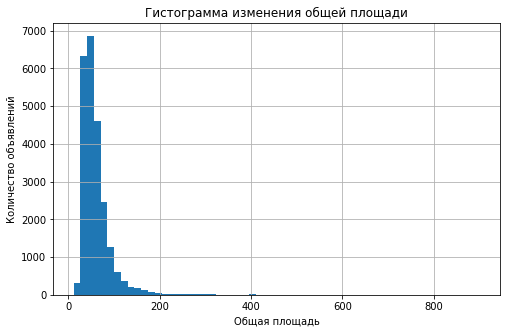

In [ ]:
data.plot(y='total_area', kind='hist', bins=60, grid=True, figsize=(8, 5), legend=False)
plt.title('Гистограмма изменения общей площади')
plt.xlabel('Общая площадь')
plt.ylabel('Количество объявлений')
plt.show()

По графику видно, что чем больше площадь квартиры, тем реже встречаются объявления. Поэтому, мы можем ограничить размер гистограммы для большей наглядности. Чтобы узнать, до какого значения ограничивать, построим диаграмму размаха, и найдем выбивающиеся значения.

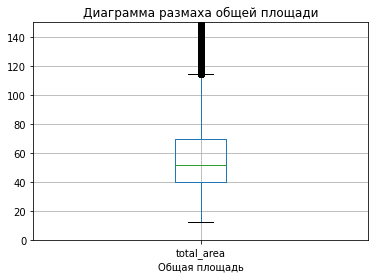

In [ ]:
data.boxplot('total_area')
plt.title('Диаграмма размаха общей площади')
plt.xlabel('Общая площадь')
plt.ylim(0, 150)
plt.show()

На графике видно, что выбивающимися значениями считаются квартиры площадью более 120 м2. Построим гистограмму с полученным ограничением.

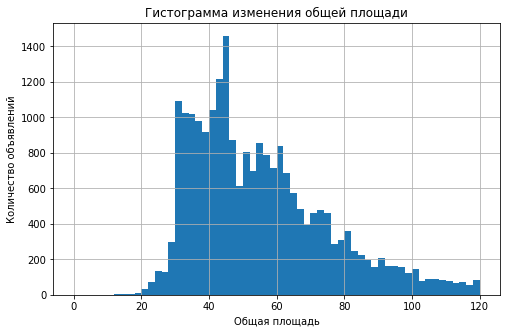

In [ ]:
#гистограмма общей площади с ограничением
data.plot(y='total_area', kind='hist', bins=60, grid=True, figsize=(8, 5), range=(0, 120), legend=False)
plt.title('Гистограмма изменения общей площади')
plt.xlabel('Общая площадь')
plt.ylabel('Количество объявлений')
plt.show()

Мы видим, что пик объявлений приходится на квартиры общей площадью около 43 м2. Чем больше площадь, тем меньше предложений по квартирам. При этом, наблюдаются просадки объявлений по квартирам с площадями около 37 и 47 м2.

<div class="alert alert-info">
    
Теперь удалим лишнее количество данных, куда войдут редкие значения. Чтобы анализ был достоверным, необходимо сохранение минимум 90 % данных после всех фильтраций.

In [ ]:
new_data = data.query('total_area <= 200')
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14.0,89.040001,9,True,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.809998,2017-03-21,3,3.70,5.0,73.300003,3,True,...,796.0,3.0,381.0,NaN,72490.85,1,3,2017,другой,4.0
23695,14,3100000.0,59.000000,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,NaN,NaN,45.0,52542.37,0,1,2018,другой,NaN
23696,18,2500000.0,56.700001,2018-02-11,2,2.65,3.0,29.700001,1,True,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475000.0,76.750000,2017-03-28,2,3.00,17.0,42.980000,12,True,...,173.0,3.0,196.0,602.0,149511.40,1,3,2017,другой,10.0


In [ ]:
new_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14.0,89.040001,9,True,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.809998,2017-03-21,3,3.70,5.0,73.300003,3,True,...,796.0,3.0,381.0,NaN,72490.85,1,3,2017,другой,4.0
23695,14,3100000.0,59.000000,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,NaN,NaN,45.0,52542.37,0,1,2018,другой,NaN
23696,18,2500000.0,56.700001,2018-02-11,2,2.65,3.0,29.700001,1,True,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475000.0,76.750000,2017-03-28,2,3.00,17.0,42.980000,12,True,...,173.0,3.0,196.0,602.0,149511.40,1,3,2017,другой,10.0


**4.1.2. Жилая площадь**

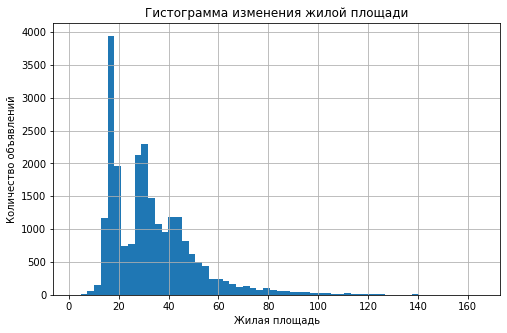

In [ ]:
new_data.plot(y='living_area', kind='hist', bins=60, grid=True, figsize=(8, 5), legend=False)
plt.title('Гистограмма изменения жилой площади')
plt.xlabel('Жилая площадь')
plt.ylabel('Количество объявлений')
plt.show()

И снова у нас имеются очень редкие значения, поэтому исключим их привычным методом.

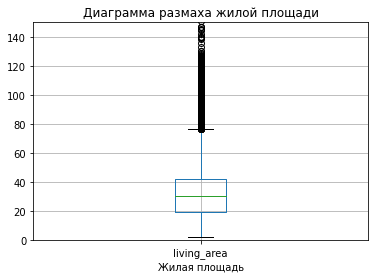

In [ ]:
new_data.boxplot('living_area')
plt.title('Диаграмма размаха жилой площади')
plt.xlabel('Жилая площадь')
plt.ylim(0, 150)
plt.show()

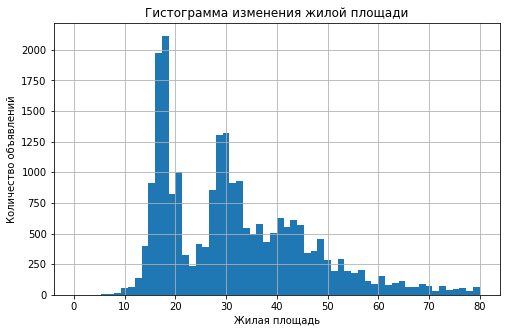

In [ ]:
new_data.plot(y='living_area', kind='hist', bins=60, grid=True, figsize=(8, 5), range=(0, 80), legend=False)
plt.title('Гистограмма изменения жилой площади')
plt.xlabel('Жилая площадь')
plt.ylabel('Количество объявлений')
plt.show()

Как и с общей площадью, у нас имеется снижение предложений квартир с увеличением жилой площади. Однако, в этот раз наблюдается большой спад объявлений по квартирам с жилой площадью от примерно 21 до 27 м2. Пиковое значение - в районе 17-18 м2.

In [ ]:
new_data = new_data.query('living_area <= 110')
new_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14.0,89.040001,9,True,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.809998,2017-03-21,3,3.70,5.0,73.300003,3,True,...,796.0,3.0,381.0,NaN,72490.85,1,3,2017,другой,4.0
23695,14,3100000.0,59.000000,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,NaN,NaN,45.0,52542.37,0,1,2018,другой,NaN
23696,18,2500000.0,56.700001,2018-02-11,2,2.65,3.0,29.700001,1,True,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475000.0,76.750000,2017-03-28,2,3.00,17.0,42.980000,12,True,...,173.0,3.0,196.0,602.0,149511.40,1,3,2017,другой,10.0


**4.1.3. Площадь кухни**

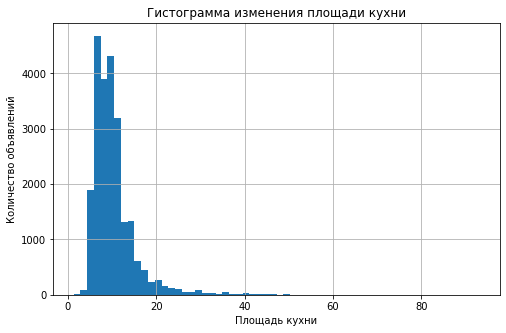

In [ ]:
new_data.plot(y='kitchen_area', kind='hist', bins=60, grid=True, figsize=(8, 5), legend=False)
plt.title('Гистограмма изменения площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Количество объявлений')
plt.show()

Рассмотрим, до какого значения необходимо ограничить гистограмму.

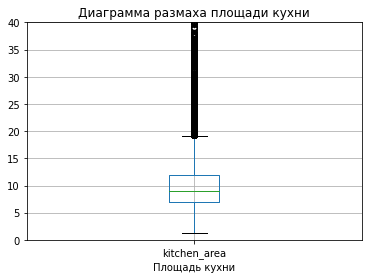

In [ ]:
new_data.boxplot('kitchen_area')
plt.title('Диаграмма размаха площади кухни')
plt.xlabel('Площадь кухни')
plt.ylim(0, 40)
plt.show()

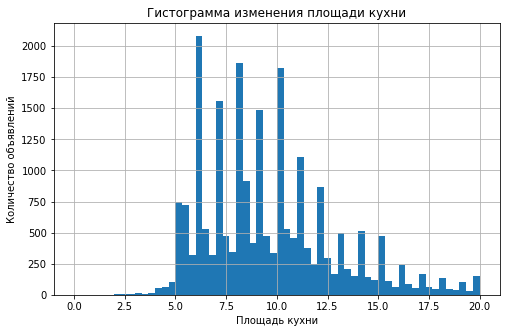

In [ ]:
new_data.plot(y='kitchen_area', kind='hist', bins=60, grid=True, figsize=(8, 5), range=(0, 20), legend=False)
plt.title('Гистограмма изменения площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Количество объявлений')
plt.show()

У площади кухни зависимость точно такая же - чем больше площадь, тем меньше количество объявлений. Однако, спады четко сменяются подъемами. Пиковое значение наблюдается в районе 5.5 м2.

In [ ]:
new_data = new_data.query('kitchen_area <= 50')
new_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14.0,89.040001,9,True,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.809998,2017-03-21,3,3.70,5.0,73.300003,3,True,...,796.0,3.0,381.0,NaN,72490.85,1,3,2017,другой,4.0
23695,14,3100000.0,59.000000,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,NaN,NaN,45.0,52542.37,0,1,2018,другой,NaN
23696,18,2500000.0,56.700001,2018-02-11,2,2.65,3.0,29.700001,1,True,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475000.0,76.750000,2017-03-28,2,3.00,17.0,42.980000,12,True,...,173.0,3.0,196.0,602.0,149511.40,1,3,2017,другой,10.0


**4.1.4. Цена объекта**

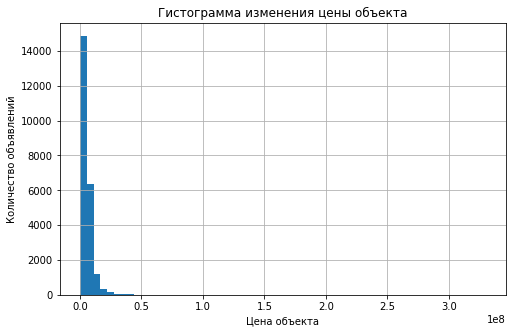

In [ ]:
new_data.plot(y='last_price', kind='hist', bins=60, grid=True, figsize=(8, 5), legend=False)
plt.title('Гистограмма изменения цены объекта')
plt.xlabel('Цена объекта')
plt.ylabel('Количество объявлений')
plt.show()

Гистограмма получилась очень странной, посмотрим сведения о столбце.

In [ ]:
new_data['last_price'].describe()

count    2.309700e+04
mean     5.924610e+06
std      5.883184e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.630000e+06
max      3.300000e+08
Name: last_price, dtype: float64

Метод *describe()* показал, что в данных столбца цены имеются аномально высокие значения. Для корректного отображения, поделим все значения цены на 1000, и приведем тип данных столбца к *int.*

In [ ]:
new_data['last_price'] = new_data['last_price'] / 1000
new_data['last_price'] = new_data['last_price'].astype('int')

/tmp/ipykernel_163/829015178.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['last_price'] = new_data['last_price'] / 1000
/tmp/ipykernel_163/829015178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['last_price'] = new_data['last_price'].astype('int')


Снова выведем данные о столбце.

In [ ]:
new_data['last_price'].describe()

count     23097.000000
mean       5924.593887
std        5883.175900
min          12.000000
25%        3400.000000
50%        4600.000000
75%        6630.000000
max      330000.000000
Name: last_price, dtype: float64

Данные в порядке, теперь можем визуализировать. Сначала посмотрим на диаграмму размаха.

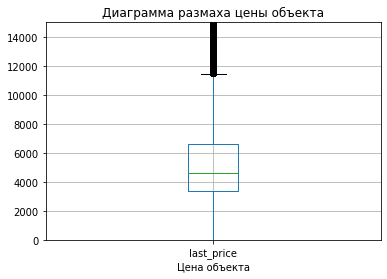

In [ ]:
new_data.boxplot('last_price')
plt.title('Диаграмма размаха цены объекта')
plt.xlabel('Цена объекта')
plt.ylim(0, 15000)
plt.show()

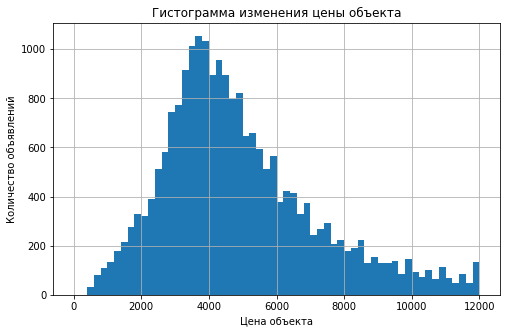

In [ ]:
new_data.plot(y='last_price', kind='hist', bins=60, grid=True, figsize=(8, 5), range=(0, 12000), legend=False)
plt.title('Гистограмма изменения цены объекта')
plt.xlabel('Цена объекта')
plt.ylabel('Количество объявлений')
plt.show()

Получили гистограмму с распределением Пуассона. Здесь четко виден пик цены - в районе 3800 тыс. И точно так же, более высокая цена встречается реже.

In [ ]:
new_data = new_data.query('last_price <= 15000')
new_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
4,2,10000,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
5,10,2890,30.400000,2018-09-10,1,2.65,12.0,14.400000,5,True,...,NaN,NaN,NaN,55.0,95065.79,0,9,2018,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700,133.809998,2017-03-21,3,3.70,5.0,73.300003,3,True,...,796.0,3.0,381.0,NaN,72490.85,1,3,2017,другой,4.0
23695,14,3100,59.000000,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,NaN,NaN,45.0,52542.37,0,1,2018,другой,NaN
23696,18,2500,56.700001,2018-02-11,2,2.65,3.0,29.700001,1,True,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475,76.750000,2017-03-28,2,3.00,17.0,42.980000,12,True,...,173.0,3.0,196.0,602.0,149511.40,1,3,2017,другой,10.0


**4.1.5. Количество комнат**

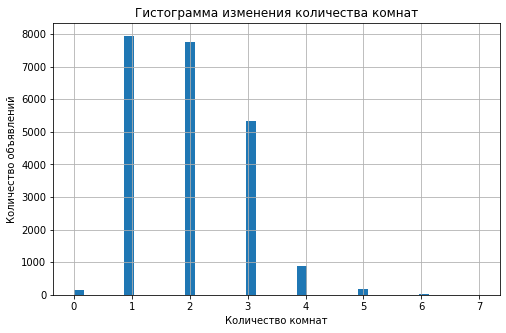

In [ ]:
new_data.plot(y='rooms', kind='hist', bins=40, grid=True, figsize=(8, 5), legend=False)
plt.title('Гистограмма изменения количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')
plt.show()

На гистограмме, помимо редких значений, отчетливо видно, что имеются объявления, где значение "количество комнат" равно нулю. Попробуем изучить такие строки, возможно, за такими данными скрываются квартиры-студии.

In [ ]:
new_data.query('rooms == 0 and studio == True')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
144,1,2450,27.0,2017-03-30,0,2.65,24.0,15.500000,2,True,...,NaN,NaN,NaN,181.0,90740.74,3,3,2017,другой,NaN
608,2,1850,25.0,2019-02-20,0,2.65,10.0,14.000000,7,True,...,NaN,NaN,NaN,29.0,74000.00,2,2,2019,другой,NaN
716,5,1500,17.0,2017-06-07,0,2.70,9.0,12.000000,1,True,...,NaN,0.0,NaN,40.0,88235.29,2,6,2017,первый,30.0
1173,12,3240,29.0,2018-10-30,0,2.65,24.0,17.000000,2,True,...,NaN,1.0,475.0,13.0,111724.14,1,10,2018,другой,16.0
1174,3,3900,32.0,2016-10-18,0,2.70,24.0,18.000000,2,True,...,609.0,0.0,NaN,540.0,121875.00,1,10,2016,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22867,8,3090,30.0,2017-12-17,0,2.65,25.0,18.200001,5,True,...,NaN,1.0,400.0,211.0,103000.00,6,12,2017,другой,16.0
22877,2,4280,28.0,2017-10-26,0,2.70,19.0,18.000000,10,True,...,NaN,1.0,415.0,151.0,152857.14,3,10,2017,другой,7.0
23210,7,3200,26.0,2017-09-01,0,2.65,25.0,18.000000,16,True,...,NaN,1.0,623.0,14.0,123076.92,4,9,2017,другой,13.0
23554,15,3350,26.0,2018-09-07,0,2.65,19.0,14.560000,8,True,...,NaN,2.0,112.0,31.0,128846.15,4,9,2018,другой,17.0


In [ ]:
new_data.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
144,1,2450,27.000000,2017-03-30,0,2.65,24.0,15.500000,2,True,...,NaN,NaN,NaN,181.0,90740.74,3,3,2017,другой,NaN
349,4,2320,25.000000,2017-09-27,0,2.65,14.0,17.000000,1,True,...,NaN,NaN,NaN,45.0,92800.00,2,9,2017,первый,NaN
508,0,3375,34.400002,2017-03-28,0,2.65,26.0,24.299999,19,True,...,NaN,1.0,593.0,430.0,98110.46,1,3,2017,другой,19.0
608,2,1850,25.000000,2019-02-20,0,2.65,10.0,14.000000,7,True,...,NaN,NaN,NaN,29.0,74000.00,2,2,2019,другой,NaN
716,5,1500,17.000000,2017-06-07,0,2.70,9.0,12.000000,1,True,...,NaN,0.0,NaN,40.0,88235.29,2,6,2017,первый,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200,26.000000,2017-09-01,0,2.65,25.0,18.000000,16,True,...,NaN,1.0,623.0,14.0,123076.92,4,9,2017,другой,13.0
23442,0,2500,27.700001,2017-09-28,0,2.65,24.0,18.000000,4,True,...,NaN,NaN,NaN,4.0,90252.71,3,9,2017,другой,NaN
23554,15,3350,26.000000,2018-09-07,0,2.65,19.0,14.560000,8,True,...,NaN,2.0,112.0,31.0,128846.15,4,9,2018,другой,17.0
23592,10,1450,29.000000,2017-11-11,0,2.65,9.0,18.000000,8,True,...,NaN,NaN,NaN,82.0,50000.00,5,11,2017,другой,NaN


Мы видим, что большинство объявлений, где указано нулевое количество комнат, являются студиями - 93 из 133. Предлагаю заменить значения в этих строках на "1", а остальные строки при построении гистограммы отбросить.

In [ ]:
new_data.loc[(new_data['rooms'] == 0) & (new_data['studio'] == True), 'rooms'] = 1
new_data.query('rooms == 0 and studio == True')

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km


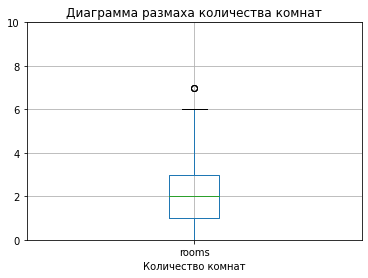

In [ ]:
new_data.boxplot('rooms')
plt.title('Диаграмма размаха количества комнат')
plt.xlabel('Количество комнат')
plt.ylim(0, 10)
plt.show()

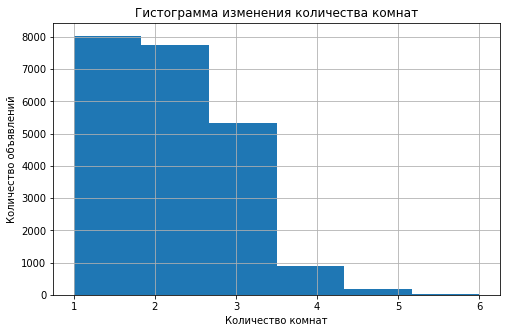

In [ ]:
new_data.plot(y='rooms', kind='hist', bins=6, grid=True, figsize=(8, 5), range=(1, 6), legend=False)
plt.title('Гистограмма изменения количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')
plt.show()

На гистограмме видно, что чаще всего продаются квартиры с 1, 2 и 3 комнатами. Начиная с 4 комнат, объявления встречаются намного реже.

In [ ]:
new_data = new_data.query('1 <= rooms <= 6')
new_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
4,2,10000,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
5,10,2890,30.400000,2018-09-10,1,2.65,12.0,14.400000,5,True,...,NaN,NaN,NaN,55.0,95065.79,0,9,2018,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700,133.809998,2017-03-21,3,3.70,5.0,73.300003,3,True,...,796.0,3.0,381.0,NaN,72490.85,1,3,2017,другой,4.0
23695,14,3100,59.000000,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,NaN,NaN,45.0,52542.37,0,1,2018,другой,NaN
23696,18,2500,56.700001,2018-02-11,2,2.65,3.0,29.700001,1,True,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475,76.750000,2017-03-28,2,3.00,17.0,42.980000,12,True,...,173.0,3.0,196.0,602.0,149511.40,1,3,2017,другой,10.0


**4.1.6. Высота потолков**

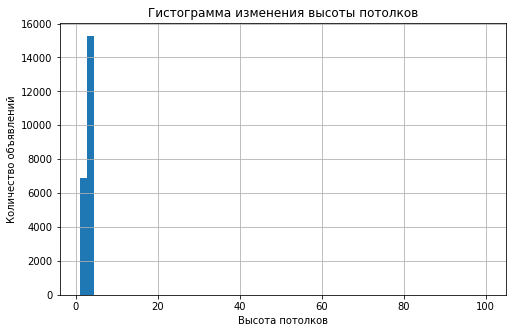

In [ ]:
new_data.plot(y='ceiling_height', kind='hist', bins=60, grid=True, figsize=(8, 5), legend=False)
plt.title('Гистограмма изменения высоты потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество объявлений')
plt.show()

На гистограмме видно, что есть типичные значения, и в отдельности есть аномальные значения, которые портят визуализацию. Попробуем обработать эти аномалии.

In [ ]:
new_data['ceiling_height'] = new_data['ceiling_height'].where(new_data['ceiling_height'] <= 22, new_data['ceiling_height'] / 10)
new_data['ceiling_height'].sort_values(ascending=False).unique()

/tmp/ipykernel_163/3948787296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['ceiling_height'] = new_data['ceiling_height'].where(new_data['ceiling_height'] <= 22, new_data['ceiling_height'] / 10)


array([20.  , 14.  , 10.3 , 10.  ,  8.3 ,  8.  ,  5.3 ,  5.  ,  4.8 ,
        4.7 ,  4.5 ,  4.4 ,  4.37,  4.3 ,  4.25,  4.2 ,  4.19,  4.15,
        4.14,  4.1 ,  4.06,  4.  ,  3.98,  3.95,  3.93,  3.9 ,  3.88,
        3.85,  3.84,  3.83,  3.8 ,  3.78,  3.75,  3.7 ,  3.68,  3.67,
        3.66,  3.65,  3.63,  3.62,  3.6 ,  3.59,  3.57,  3.56,  3.55,
        3.54,  3.53,  3.52,  3.5 ,  3.49,  3.48,  3.47,  3.46,  3.45,
        3.44,  3.42,  3.4 ,  3.39,  3.38,  3.37,  3.36,  3.35,  3.34,
        3.33,  3.32,  3.31,  3.3 ,  3.28,  3.27,  3.26,  3.25,  3.24,
        3.23,  3.22,  3.21,  3.2 ,  3.18,  3.17,  3.16,  3.15,  3.14,
        3.13,  3.12,  3.11,  3.1 ,  3.09,  3.08,  3.07,  3.06,  3.05,
        3.04,  3.03,  3.02,  3.01,  3.  ,  2.99,  2.98,  2.97,  2.96,
        2.95,  2.94,  2.93,  2.92,  2.91,  2.9 ,  2.89,  2.88,  2.87,
        2.86,  2.85,  2.84,  2.83,  2.82,  2.81,  2.8 ,  2.79,  2.78,
        2.77,  2.76,  2.75,  2.74,  2.73,  2.72,  2.71,  2.7 ,  2.69,
        2.68,  2.67,

Аномалии обработаны там, где это было возможно. Остальные значения можно будет отбросить при построении гистограммы.

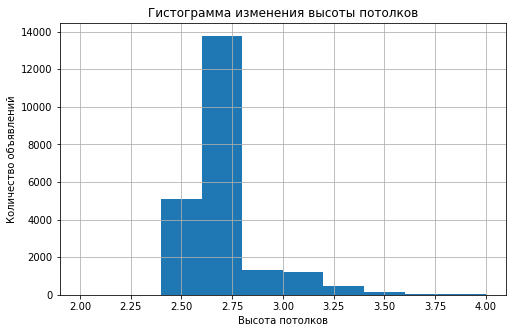

In [ ]:
new_data.plot(y='ceiling_height', kind='hist', grid=True, figsize=(8, 5), range=(2, 4), legend=False)
plt.title('Гистограмма изменения высоты потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество объявлений')
plt.show()

Пик объявлений приходится на квартиры с высотой потолков от 2.6 до 2.75 м. В 2 раза меньше показатель высоты в размере 2.5 м. Больше 2.75 м начинается большой спад, и объявления встречаются все реже и реже.

In [ ]:
new_data = new_data.query('2 <= ceiling_height <= 4')
new_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
4,2,10000,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
5,10,2890,30.400000,2018-09-10,1,2.65,12.0,14.400000,5,True,...,NaN,NaN,NaN,55.0,95065.79,0,9,2018,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700,133.809998,2017-03-21,3,3.70,5.0,73.300003,3,True,...,796.0,3.0,381.0,NaN,72490.85,1,3,2017,другой,4.0
23695,14,3100,59.000000,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,NaN,NaN,45.0,52542.37,0,1,2018,другой,NaN
23696,18,2500,56.700001,2018-02-11,2,2.65,3.0,29.700001,1,True,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475,76.750000,2017-03-28,2,3.00,17.0,42.980000,12,True,...,173.0,3.0,196.0,602.0,149511.40,1,3,2017,другой,10.0


**4.1.7. Тип этажа квартиры**

Так как типов этажа 3, нагляднее всего будет построить круговую диаграмму. Для этого создадим сводную таблицу.

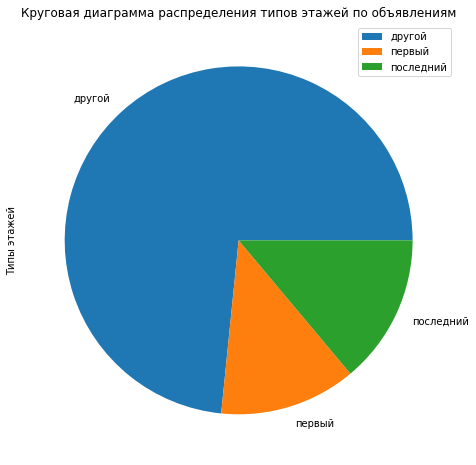

,floor,percent
type_floor,,
другой,16246,73.398392
первый,2812,12.704437
последний,3076,13.897172


In [ ]:
floor_percent = new_data.pivot_table(index='type_floor', values='floor', aggfunc='count')
floor_percent['percent'] = (floor_percent['floor'] / floor_percent['floor'].sum()) * 100

floor_percent.plot(y='floor', kind='pie', figsize=(8, 8))
plt.title('Круговая диаграмма распределения типов этажей по объявлениям')
plt.ylabel('Типы этажей')
plt.show()
floor_percent

На диаграмме видно, что объявлений с квартирами на первом этаже меньше всего - 12.7 %. Немногим больше квартир на последнем этаже - 13.9 %. И, конечно же, основную часть занимают "другие" квартиры - целых 73.4 %.

**4.1.8. Общее количество этажей в доме**

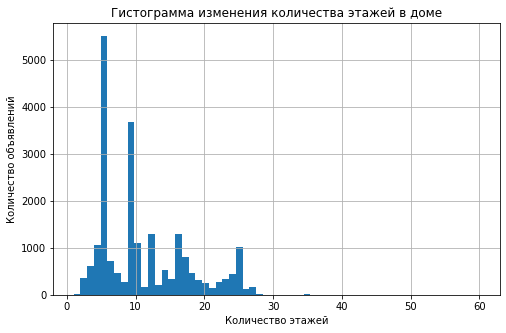

In [ ]:
new_data.plot(y='floors_total', kind='hist', bins=60, grid=True, figsize=(8, 5), legend=False)
plt.title('Гистограмма изменения количества этажей в доме')
plt.xlabel('Количество этажей')
plt.ylabel('Количество объявлений')
plt.show()

Видно, что в этом столбце есть редкие значения. Избавимся от них, задав ограничение.

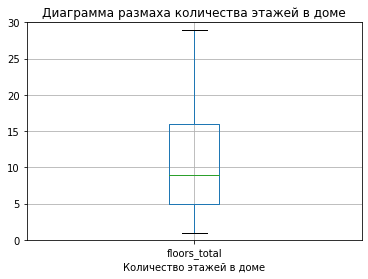

In [ ]:
new_data.boxplot('floors_total')
plt.title('Диаграмма размаха количества этажей в доме')
plt.xlabel('Количество этажей в доме')
plt.ylim(0, 30)
plt.show()

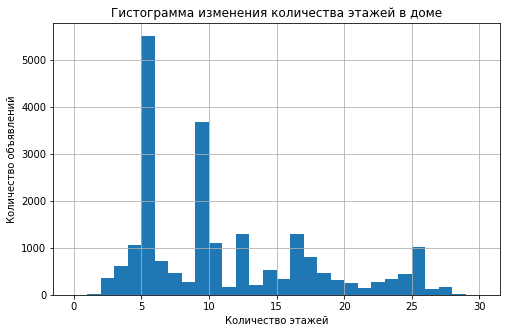

In [ ]:
new_data.plot(y='floors_total', kind='hist', bins=30, grid=True, figsize=(8, 5), range=(0, 30), legend=False)
plt.title('Гистограмма изменения количества этажей в доме')
plt.xlabel('Количество этажей')
plt.ylabel('Количество объявлений')
plt.show()

Чаще всего встречаются объявление с 5 этажами. На втором месте - объявления, где указано 10 этажей. В остальном, до 30 этажей нет четкой зависимости изменения количества объявлений. Снижение начинается только после 30 этажей, так как там уже попадаются редкие значения.

In [ ]:
new_data = new_data.query('floors_total <= 30')
new_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
4,2,10000,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
5,10,2890,30.400000,2018-09-10,1,2.65,12.0,14.400000,5,True,...,NaN,NaN,NaN,55.0,95065.79,0,9,2018,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700,133.809998,2017-03-21,3,3.70,5.0,73.300003,3,True,...,796.0,3.0,381.0,NaN,72490.85,1,3,2017,другой,4.0
23695,14,3100,59.000000,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,NaN,NaN,45.0,52542.37,0,1,2018,другой,NaN
23696,18,2500,56.700001,2018-02-11,2,2.65,3.0,29.700001,1,True,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475,76.750000,2017-03-28,2,3.00,17.0,42.980000,12,True,...,173.0,3.0,196.0,602.0,149511.40,1,3,2017,другой,10.0


**4.1.9. Расстояние до центра города в метрах**

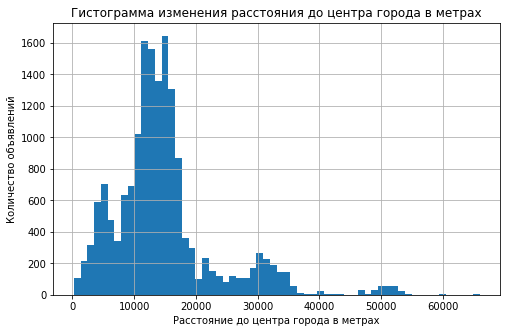

In [ ]:
new_data.plot(y='cityCenters_nearest', kind='hist', bins=60, grid=True, figsize=(8, 5), legend=False)
plt.title('Гистограмма изменения расстояния до центра города в метрах')
plt.xlabel('Расстояние до центра города в метрах')
plt.ylabel('Количество объявлений')
plt.show()

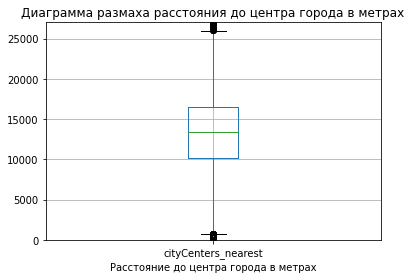

In [ ]:
new_data.boxplot('cityCenters_nearest')
plt.title('Диаграмма размаха расстояния до центра города в метрах')
plt.xlabel('Расстояние до центра города в метрах')
plt.ylim(0, 27000)
plt.show()

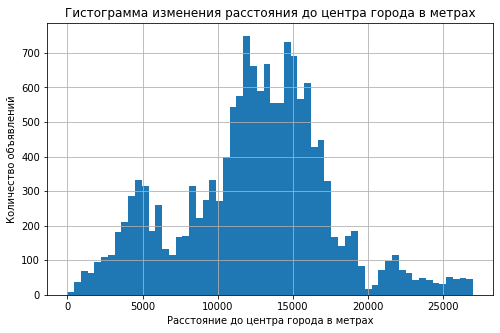

In [ ]:
new_data.plot(y='cityCenters_nearest', kind='hist', bins=60, grid=True, figsize=(8, 5), range=(0, 27000), legend=False)
plt.title('Гистограмма изменения расстояния до центра города в метрах')
plt.xlabel('Расстояние до центра города в метрах')
plt.ylabel('Количество объявлений')
plt.show()

У нас имеются 2 почти равнозначных пика - на показателях 12000 и 15000 м. Есть также большое количество объявлений с показателем в 5000 м. В остальном, как и обычно, чем дольше удаление от центра, тем меньше объявлений.

In [ ]:
new_data = new_data.query('cityCenters_nearest.isna() or cityCenters_nearest <= 35000')
new_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
4,2,10000,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
5,10,2890,30.400000,2018-09-10,1,2.65,12.0,14.400000,5,True,...,NaN,NaN,NaN,55.0,95065.79,0,9,2018,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700,133.809998,2017-03-21,3,3.70,5.0,73.300003,3,True,...,796.0,3.0,381.0,NaN,72490.85,1,3,2017,другой,4.0
23695,14,3100,59.000000,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,NaN,NaN,45.0,52542.37,0,1,2018,другой,NaN
23696,18,2500,56.700001,2018-02-11,2,2.65,3.0,29.700001,1,True,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475,76.750000,2017-03-28,2,3.00,17.0,42.980000,12,True,...,173.0,3.0,196.0,602.0,149511.40,1,3,2017,другой,10.0


**4.1.10. Расстояние до ближайшего парка**

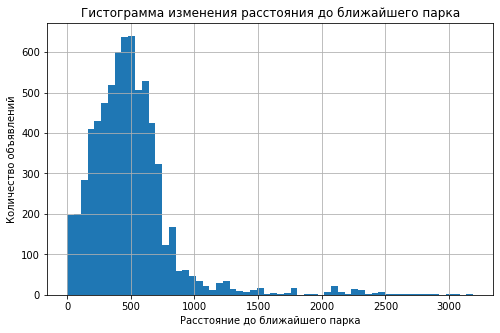

In [ ]:
new_data.plot(y='parks_nearest', kind='hist', bins=60, grid=True, figsize=(8, 5), legend=False)
plt.title('Гистограмма изменения расстояния до ближайшего парка')
plt.xlabel('Расстояние до ближайшего парка')
plt.ylabel('Количество объявлений')
plt.show()

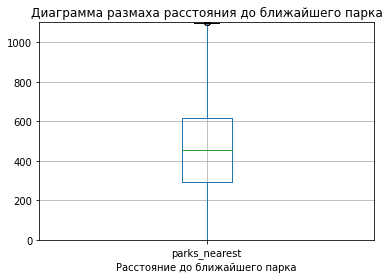

In [ ]:
new_data.boxplot('parks_nearest')
plt.title('Диаграмма размаха расстояния до ближайшего парка')
plt.xlabel('Расстояние до ближайшего парка')
plt.ylim(0, 1100)
plt.show()

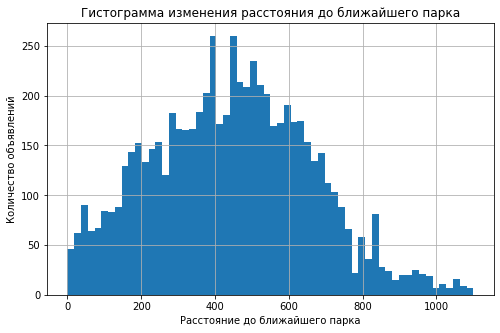

In [ ]:
new_data.plot(y='parks_nearest', kind='hist', bins=60, grid=True, figsize=(8, 5), range=(0, 1100), legend=False)
plt.title('Гистограмма изменения расстояния до ближайшего парка')
plt.xlabel('Расстояние до ближайшего парка')
plt.ylabel('Количество объявлений')
plt.show()

Есть 2 пика - на 400 и 450 м. Чем больше отдаление от парка, тем меньше объявлений.

In [ ]:
new_data = new_data.query('parks_nearest.isna() or parks_nearest <= 1300')
new_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
4,2,10000,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
5,10,2890,30.400000,2018-09-10,1,2.65,12.0,14.400000,5,True,...,NaN,NaN,NaN,55.0,95065.79,0,9,2018,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700,133.809998,2017-03-21,3,3.70,5.0,73.300003,3,True,...,796.0,3.0,381.0,NaN,72490.85,1,3,2017,другой,4.0
23695,14,3100,59.000000,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,NaN,NaN,45.0,52542.37,0,1,2018,другой,NaN
23696,18,2500,56.700001,2018-02-11,2,2.65,3.0,29.700001,1,True,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475,76.750000,2017-03-28,2,3.00,17.0,42.980000,12,True,...,173.0,3.0,196.0,602.0,149511.40,1,3,2017,другой,10.0


In [ ]:
data.shape[0]

23650

<div class="alert alert-info">

Рассчет данных после фильтрации проведен в конце пункта 4.2.

Таким образом, были рассмотрены и проанализированы несколько параметров объектов, обработаны аномалии, построены гистограммы для визуализации.

### Изучение скорости продажи квартир

Чтобы изучить динамику продажи квартир, построем гистограмму, посчитаем среднее и медиану, и постараемся ответить на вопрос: какие продажи можно считать быстрыми и необычайно долгими.

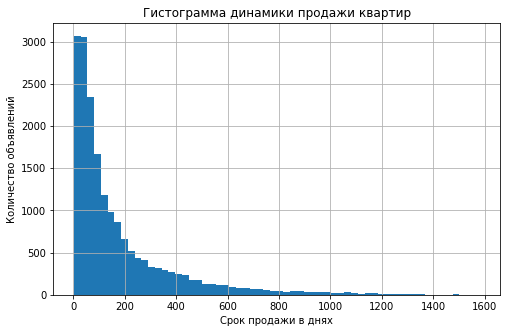

In [ ]:
new_data.plot(y='days_exposition', kind='hist', bins=60, grid=True, figsize=(8, 5), legend=False)
plt.title('Гистограмма динамики продажи квартир')
plt.xlabel('Срок продажи в днях')
plt.ylabel('Количество объявлений')
plt.show()

In [ ]:
print('Квартиры в среднем продавались', new_data['days_exposition'].mean().round(), 'день')
print('Медиана продажи квартир:', new_data['days_exposition'].median().round(), 'дней')

Квартиры в среднем продавались 175.0 день
Медиана продажи квартир: 92.0 дней


Отсеем редкие значения с помощью диаграммы размаха.

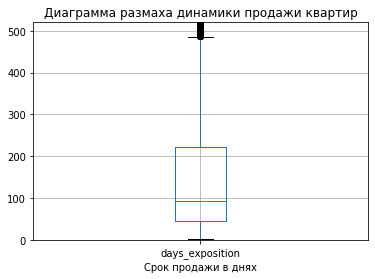

In [ ]:
new_data.boxplot('days_exposition')
plt.title('Диаграмма размаха динамики продажи квартир')
plt.xlabel('Срок продажи в днях')
plt.ylim(0, 520)
plt.show()

Построим новую гистограмму с полученным ограничением.

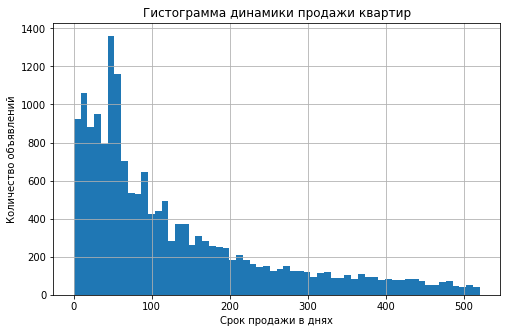

In [ ]:
new_data.plot(y='days_exposition', kind='hist', bins=60, grid=True, figsize=(8, 5), range=(0, 520), legend=False)
plt.title('Гистограмма динамики продажи квартир')
plt.xlabel('Срок продажи в днях')
plt.ylabel('Количество объявлений')
plt.show()

<div class="alert alert-info">
    
Удалим редкие значения.

In [ ]:
new_data = new_data.query('days_exposition.isna() or days_exposition <= 1100')
new_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday,month,year,type_floor,cityCenters_km
0,20,13000,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
4,2,10000,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0
5,10,2890,30.400000,2018-09-10,1,2.65,12.0,14.400000,5,True,...,NaN,NaN,NaN,55.0,95065.79,0,9,2018,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700,133.809998,2017-03-21,3,3.70,5.0,73.300003,3,True,...,796.0,3.0,381.0,NaN,72490.85,1,3,2017,другой,4.0
23695,14,3100,59.000000,2018-01-15,3,2.65,5.0,38.000000,4,True,...,NaN,NaN,NaN,45.0,52542.37,0,1,2018,другой,NaN
23696,18,2500,56.700001,2018-02-11,2,2.65,3.0,29.700001,1,True,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475,76.750000,2017-03-28,2,3.00,17.0,42.980000,12,True,...,173.0,3.0,196.0,602.0,149511.40,1,3,2017,другой,10.0


<div class="alert alert-info">

Теперь определим быстрые и долгие продажи. Для этого выведем сведения о столбце.

In [ ]:
new_data['days_exposition'].describe()

count    18596.000000
mean       167.922188
std        194.902030
min          1.000000
25%         44.000000
50%         92.000000
75%        217.000000
max       1100.000000
Name: days_exposition, dtype: float64

<div class="alert alert-info">

Первый квартиль равен **44 дням.** Такой срок предлагаю считать быстрым. Третий квартиль показывает **217 дней,** такой срок предлагаю считать долгим.

<div class="alert alert-info">
    
После всех фильтраций, проверим количество строк нового датафрейма.

In [ ]:
data_size = data.shape[0]
new_data_size = new_data.shape[0]
new_data_size / data_size * 100

90.08033826638477

Данных осталось больше 90 %, а значит мы можем проводить дальнейший анализ.

### Определение факторов, влияющих на стоимость

**4.3.1. Определение зависимости цены от общей площади**

Для определения зависимости воспользуемся диаграммой рассеяния и коэффициентом корреляции Пирсона. При построении диаграмм рассеяния будем ориентироваться на ограничения графиков, заданных ранее. Немного увеличим эти границы, чтобы посмотреть на изменения.

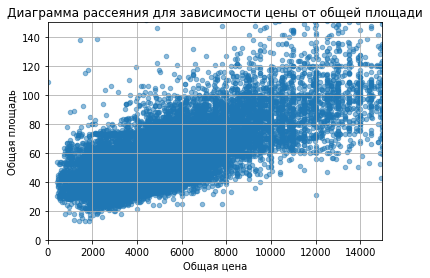

In [ ]:
new_data.plot(x='last_price', y='total_area', kind='scatter', grid=True, alpha=0.5)
plt.title('Диаграмма рассеяния для зависимости цены от общей площади')
plt.xlabel('Общая цена')
plt.ylabel('Общая площадь')
plt.xlim(0, 15000)
plt.ylim(0, 150)
plt.show()

In [ ]:
new_data['last_price'].corr(new_data['total_area'])

0.7416781690652247

Мы видим, что зависимость есть - чем больше общая площадь, тем больше цена. Однако, зависимость не очень сильная, так как, скорее всего, на цену может влиять третий параметр.

**4.3.2. Определение зависимости цены от жилой площади**

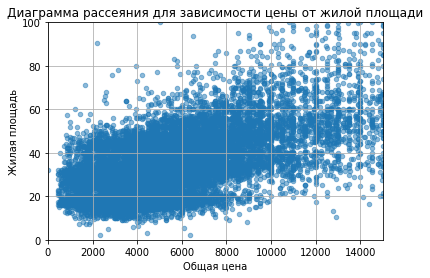

In [ ]:
new_data.plot(x='last_price', y='living_area', kind='scatter', grid=True, alpha=0.5)
plt.title('Диаграмма рассеяния для зависимости цены от жилой площади')
plt.xlabel('Общая цена')
plt.ylabel('Жилая площадь')
plt.xlim(0, 15000)
plt.ylim(0, 100)
plt.show()

In [ ]:
new_data['last_price'].corr(new_data['living_area'])

0.6314825470013248

Несмотря на имеющуюся прямую зависимость, она еще меньше, чем общая площадь. Снова делаем вывод о третьем факторе.

**4.3.3. Определение зависимости цены от площади кухни**

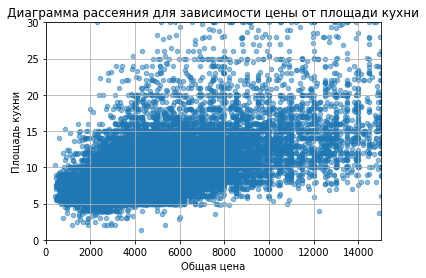

In [ ]:
new_data.plot(x='last_price', y='kitchen_area', kind='scatter', grid=True, alpha=0.5)
plt.title('Диаграмма рассеяния для зависимости цены от площади кухни')
plt.xlabel('Общая цена')
plt.ylabel('Площадь кухни')
plt.xlim(0, 15000)
plt.ylim(0, 30)
plt.show()

In [ ]:
new_data['last_price'].corr(new_data['kitchen_area'])

0.551961671938739

Площадь кухни имеет самое слабое влияние на цену из площадей. Очевидно, что чем больше площадь кухни, тем должна быть больше общая площадь, а значит и цена. Но прямая зависимость очень слаба.

**4.3.4. Определение зависимости цены от количества комнат**

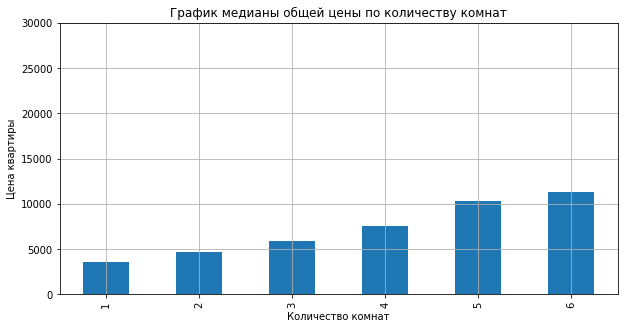

In [ ]:
(
    new_data.query('1 <= rooms <= 7').pivot_table(index='rooms', values='last_price', aggfunc='median')
    .plot(y='last_price', kind='bar', figsize=(10, 5), grid=True, legend=False)
)
plt.title('График медианы общей цены по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена квартиры')
plt.ylim(0, 30000)
plt.show()

<div class="alert alert-info">

На графике видно, что чем больше количество комнат, тем выше медиана общей цены. Отсюда можно сделать вывод, что количество комнат напрямую влияет на стоимость квартиры.

**4.3.5. Определение зависимости цены от типа этажа**

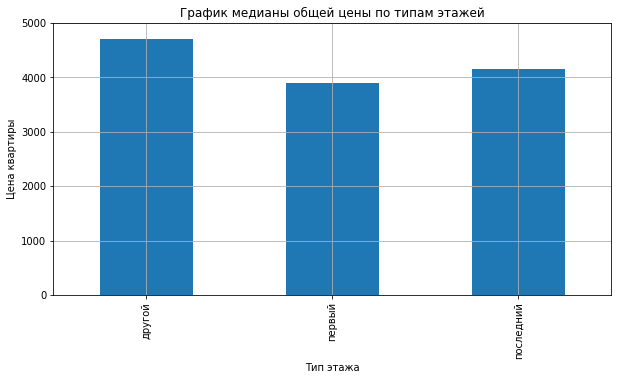

In [ ]:
(
    new_data.pivot_table(index='type_floor', values='last_price', aggfunc='median')
    .plot(y='last_price', kind='bar', figsize=(10, 5), grid=True, legend=False)
)
plt.title('График медианы общей цены по типам этажей')
plt.xlabel('Тип этажа')
plt.ylabel('Цена квартиры')
plt.ylim(0, 5000)
plt.show()

In [ ]:
new_data.pivot_table(index='type_floor', values='last_price', aggfunc='median')

,last_price
type_floor,
другой,4700
первый,3890
последний,4150


<div class="alert alert-info">

Из полученного графика делаем вывод, что тип этажа влияет на стоимость квартиры. Квартиры ниже последнего и выше первого этажа стоят дороже.

**4.3.6. Определение зависимости цены от дня недели**

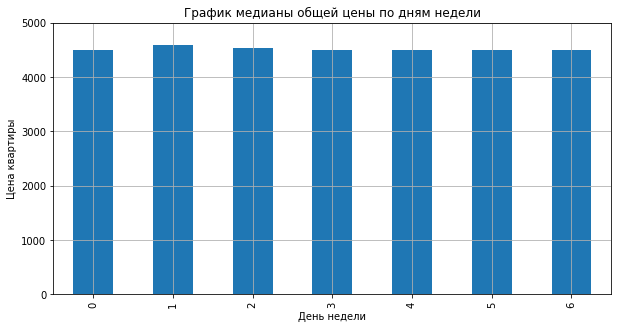

In [ ]:
(
    new_data.pivot_table(index='weekday', values='last_price', aggfunc='median')
    .plot(y='last_price', kind='bar', figsize=(10, 5), grid=True, legend=False)
)
plt.title('График медианы общей цены по дням недели')
plt.xlabel('День недели')
plt.ylabel('Цена квартиры')
plt.ylim(0, 5000)
plt.show()

In [ ]:
new_data.pivot_table(index='weekday', values='last_price', aggfunc='median')

,last_price
weekday,
0,4500.0
1,4597.0
2,4539.0
3,4500.0
4,4499.0
5,4500.0
6,4492.5


<div class="alert alert-info">

Полученные данные показывают, что во вторник самая высокая медианная цена. Начиная со вторника, цены падают, что наводит на следующую мысль: покупать квартиру лучше всего на выходных.

**4.3.7. Определение зависимости цены от месяца**

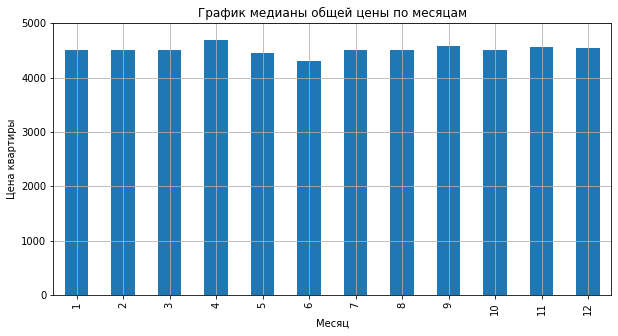

In [ ]:
(
    new_data.pivot_table(index='month', values='last_price', aggfunc='median')
    .plot(y='last_price', kind='bar', figsize=(10, 5), grid=True, legend=False)
)
plt.title('График медианы общей цены по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Цена квартиры')
plt.ylim(0, 5000)
plt.show()

In [ ]:
new_data.pivot_table(index='month', values='last_price', aggfunc='median')

,last_price
month,
1,4500
2,4500
3,4500
4,4690
5,4450
6,4297
7,4500
8,4500
9,4580


<div class="alert alert-info">

Месяц в целом не влияет на стоимость квартиры. Однако, мы можем видеть, что в **апреле** самая большая цена, в **июне** - самая маленькая.

**4.3.8. Определение зависимости цены от года**

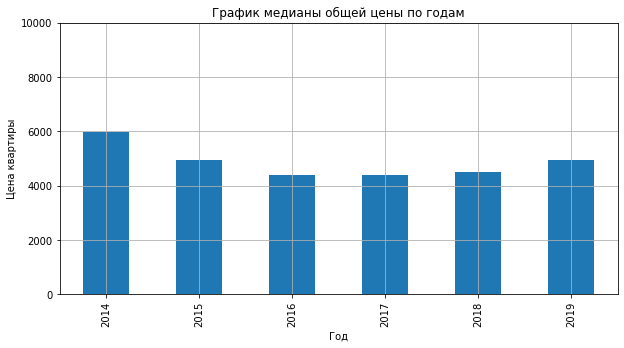

In [ ]:
(
    new_data.pivot_table(index='year', values='last_price', aggfunc='median')
    .plot(y='last_price', kind='bar', figsize=(10, 5), grid=True, legend=False)
)
plt.title('График медианы общей цены по годам')
plt.xlabel('Год')
plt.ylabel('Цена квартиры')
plt.ylim(0, 10000)
plt.show()

<div class="alert alert-info">

График показал, что в **2014 году** были самые высокие цены, после чего они начали падать. Однако, в **2019 году** цены начали расти, предположительно. Попробуем выяснить, почему, возможно, дело в третьем факторе, например, в общей площади.

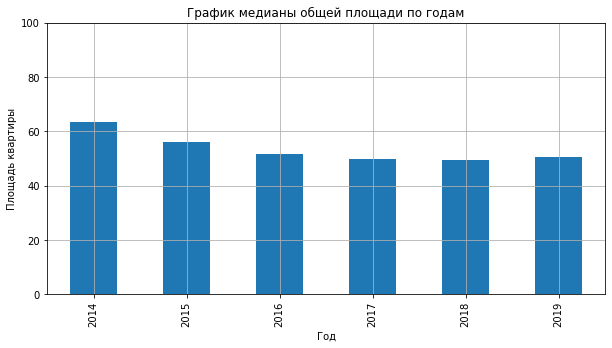

In [ ]:
(
    new_data.pivot_table(index='year', values='total_area', aggfunc='median')
    .plot(y='total_area', kind='bar', figsize=(10, 5), grid=True, legend=False)
)
plt.title('График медианы общей площади по годам')
plt.xlabel('Год')
plt.ylabel('Площадь квартиры')
plt.ylim(0, 100)
plt.show()

Так и есть, цена на квартиры уменьшалась, так как уменьшалась площадь продаваемых квартир.

<div class="alert alert-info">

Таким образом, из всех исследованных параметров, **прямое влияние на цену** квартир оказали параметры «тип этажа», «количество комнат» и «день недели».

### Расчет средней стоимости одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [ ]:
top10_locality = new_data.pivot_table(index='locality_name', values='price_for_meter')
top10_locality['number'] = new_data['locality_name'].value_counts()
top10_locality.sort_values(by='number', ascending=False).head(10)

,price_for_meter,number
locality_name,,
санкт-петербург,106894.230393,14004
мурино,85742.341418,557
кудрово,95072.430748,441
шушары,78287.251812,436
всеволожск,67248.976333,390
пушкин,101416.574663,341
парголово,90275.852981,322
колпино,75293.580343,321
гатчина,68746.146287,307


Из построенной сводной таблицы видно, что **самая большая средняя цена за квадратный метр** установлена, как и ожидалось, в Санкт-Петербурге (так как это столица). **Самая низкая цена** - в Выборге.

### Расчет средней стоимости квартир в Санкт-Петербурге на разном удалении от центра

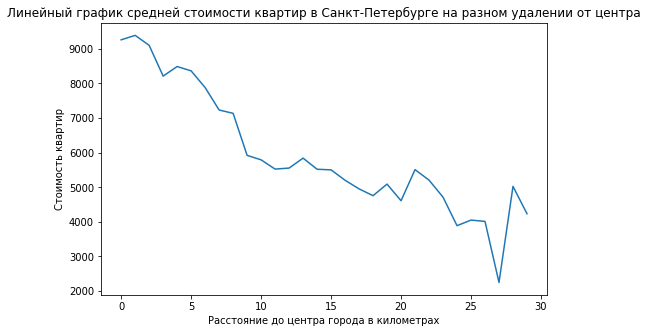

In [ ]:
price_km = new_data.query('locality_name == "санкт-петербург"').pivot_table(index='cityCenters_km', values='last_price')
price_km.plot(figsize=(8, 5), legend=False)
plt.title('Линейный график средней стоимости квартир в Санкт-Петербурге на разном удалении от центра')
plt.xlabel('Расстояние до центра города в километрах')
plt.ylabel('Стоимость квартир')
plt.show()

In [ ]:
new_data.query('locality_name == "санкт-петербург"').pivot_table(index='cityCenters_km', values='last_price')

,last_price
cityCenters_km,
0.0,9261.818182
1.0,9391.146341
2.0,9102.546729
3.0,8213.240876
4.0,8490.837383
5.0,8364.546022
6.0,7882.071739
7.0,7233.756410
8.0,7137.563008


В целом, у нас имеется зависимость падения средней цены квартир при большем удалении от центра Санкт-Петербурга. Однако, на 4 и 28 километрах наблюдается всплеск роста. Возможно, это связано с тем, что в этих районах находятся элитные жилые комплексы.

## Напишем общий вывод

<div class="alert alert-info">

В данном проекте было проведено исследование архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет на портале «Яндекс Недвижимость». По итогам исследования можно сделать следующие ключевые выводы:

- Самая высокая средняя цена за квадратный метр в размере **106894 руб.** определена в Санкт-Петербурге, что неудивительно, так как это столица. Самая низкая цена в размере **57789 руб.** - в Выборге.
- Самые большие цены обнаружены в центре города - **9391 тыс. руб.** Чем дальше от центра, тем стоимость квартир меньше (на 29 километре - **4237 тыс. руб.).** Однако, наблюдаются всплески (на 4 километре - **8491 тыс. руб.,** на 28 километре - **5026 тыс. руб.),** что наводит на мысль об элитных жилых комплексах в обустроенных районах города.
- Прямое влияние на цену квартиры оказывают следующие факторы: тип этажа *(первый, последний, другой),* количество комнат (чем выше количество, тем больше цена) и день недели (со вторника начинается снижение).

Также, стоит взять во внимание еще несколько факторов:

- Квартир на первом и последнем этажах на порядок меньше, чем остальных. Отсюда и то, что медианная стоимость квартир типа «другие» на порядок больше, чем квартир на первом и последнем этажах (**4700 тыс. руб.** против **3890 тыс. руб.** и **4150 тыс. руб.** соответственно).
- Цена квартир выше всего во вторник - **4597 тыс. руб.** В воскресенье цена самая низкая - **4492.5 тыс. руб.**
- Что касается месяцев, то в апреле самая высокая цена - **4690 тыс. руб.** Самая низкая цена - в июне **(4297 тыс. руб.).**
- Были установлены быстрые и долгие сроки продажи квартир. Быстрым сроком считается продажа в **44 дней,** долгим - **217 дней.**

Из рекомендаций могу отметить, что стоит расширить выборку, добавив более свежие данные, чтобы исследование было более актуальным и полным. Также, команде разработке стоит ввести обязательные поля для заполнения, чтобы пользователи не оставляли пустые значения. В таком случае, исследование будет более точным и объективным. В дополнение, можно ввести проверку данных перед размещением объявлений. Это не гарантирует абсолютного отсутствия ошибок и появления аномальных значений в данных, однако, их может стать на порядок меньше.